In [1]:
import sys 
sys.path.append('../')
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import numpy as np
import torch.nn.functional as F
import scipy
import pandas as pd
import os
import glob
import scienceplots
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.style.use('science')
pd.set_option('display.float_format', lambda x: '%.4e' % x)
# import seaborn as sns
from utils import create_expdf, fetch_subdf
from dataset.generate_dataset_1d import poisson_kernel, logarithm_kernel
from mpl_toolkits.axes_grid1 import make_axes_locatable
from src.utils import rl2_error

In [2]:
exp_df = create_expdf('../results')

Result of GN and GN-aug on 1D logarithm problem

In [14]:
# process green's function
idx = 257
nh = 513
h = 2/(nh-1) # x in [-1, 1]
xh = torch.linspace(-1,1,nh)
x_i = torch.cartesian_prod(xh, xh)
G = logarithm_kernel(x_i[:,0], x_i[:,1], h).numpy()#.reshape(nh, nh)
G_gn_rl2s = []
G_gnaug_rl2s = []

for i in [0,1,2,3,4]:
    gn_log_kernel = np.load('../results/logarithm/GN1D-rational-513-50-1.0000-none-{:}/approx_kernel.npy'.format(i))
    gnaug_log_kernel = np.load('../results/logarithm/GN1D-rational-513-50-1.0000-aug2-{:}/approx_kernel.npy'.format(i))
    G_gn = gn_log_kernel.reshape(-1)/(2*h) #.reshape(513,513) / h
    G_gnaug = gnaug_log_kernel/(2*h) #.reshape(513,513) / h
    G_gn_rl2s.append(rl2_error(G_gn, G))
    G_gnaug_rl2s.append(rl2_error(G_gnaug, G))


log1d_exps = exp_df[(exp_df.task_nm=='logarithm') & (exp_df.p==1)]

gn_mean = log1d_exps[log1d_exps.aug == 'none'].rl2.mean()
gn_std = log1d_exps[log1d_exps.aug == 'none'].rl2.std()

gnaug_mean = log1d_exps[log1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = log1d_exps[log1d_exps.aug == 'aug2'].rl2.std()

print("G rl2 GL : {:.3f} +/- {:.3f}".format(np.mean(G_gn_rl2s)*100, np.std(G_gn_rl2s)*100))
print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))

print("G rl2 GL-aug : {:.3f} +/- {:.3f}".format(np.mean(G_gnaug_rl2s)*100, np.std(G_gnaug_rl2s)*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))

print("G improve {:}".format(1 - np.mean(G_gnaug_rl2s)/np.mean(G_gn_rl2s)))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))


G rl2 GL : 51.316 +/- 0.058
u rl2 GL : 0.079 +/- 0.012
G rl2 GL-aug : 51.010 +/- 0.058
u rl2 GL-aug : 0.046 +/- 0.004
G improve 0.005957030975843214
u improve 0.4100497398955084


Result of GN and GN-aug on 1D poisson problem

In [3]:
# process green's function
idx = 257
nh = 513
h = 1/(nh-1) # x in [-1, 1]
xh = torch.linspace(0,1,nh)
x_i = torch.cartesian_prod(xh, xh)
G = poisson_kernel(x_i[:,0], x_i[:,1], h).numpy()#.reshape(nh, nh)
G_gn_rl2s = []
G_gnaug_rl2s = []

for i in [0,1,2,3,4]:
    gn_poisson_kernel = np.load('../results/poisson1d/GN1D-rational-513-50-1.0000-none-{:}/approx_kernel.npy'.format(i))
    gnaug_poisson_kernel = np.load('../results/poisson1d/GN1D-rational-513-50-1.0000-aug2-{:}/approx_kernel.npy'.format(i))
    G_gn = gn_poisson_kernel.reshape(-1)/h #.reshape(513,513) / h
    G_gnaug = gnaug_poisson_kernel/h #.reshape(513,513) / h
    G_gn_rl2s.append(rl2_error(G_gn, G))
    G_gnaug_rl2s.append(rl2_error(G_gnaug, G))


poisson1d_exps = exp_df[(exp_df.task_nm=='poisson1d') & (exp_df.p==1)]

gn_mean = poisson1d_exps[poisson1d_exps.aug == 'none'].rl2.mean()
gn_std = poisson1d_exps[poisson1d_exps.aug == 'none'].rl2.std()

gnaug_mean = poisson1d_exps[poisson1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = poisson1d_exps[poisson1d_exps.aug == 'aug2'].rl2.std()

print("G rl2 GL : {:.3f} +/- {:.3f}".format(np.mean(G_gn_rl2s)*100, np.std(G_gn_rl2s)*100))
print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))

print("G rl2 GL-aug : {:.3f} +/- {:.3f}".format(np.mean(G_gnaug_rl2s)*100, np.std(G_gnaug_rl2s)*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))

print("G improve {:}".format(1 - np.mean(G_gnaug_rl2s)/np.mean(G_gn_rl2s)))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))


G rl2 GL : 0.271 +/- 0.008
u rl2 GL : 0.064 +/- 0.006
G rl2 GL-aug : 0.078 +/- 0.012
u rl2 GL-aug : 0.047 +/- 0.003
G improve 0.7124315859047607
u improve 0.2644741005553356


Result of GN and GN-aug on 1D Schrodinger problem

In [29]:
G_gn_rl2s = []
G_gnaug_rl2s = []

schrodinger1d_exps = exp_df[(exp_df.task_nm=='schrodinger1d') & (exp_df.p==1)]

gn_mean = schrodinger1d_exps[schrodinger1d_exps.aug == 'none'].rl2.mean()
gn_std = schrodinger1d_exps[schrodinger1d_exps.aug == 'none'].rl2.std()

gnaug_mean = schrodinger1d_exps[schrodinger1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = schrodinger1d_exps[schrodinger1d_exps.aug == 'aug2'].rl2.std()

print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))

u rl2 GL : 0.189 +/- 0.020
u rl2 GL-aug : 0.140 +/- 0.034
u improve 0.25863743267933714


Result of GN and GN-aug on 1D Airy problem

In [30]:
G_gn_rl2s = []
G_gnaug_rl2s = []

airy1d_exps = exp_df[(exp_df.task_nm=='airy1d') & (exp_df.p==1)]

gn_mean = airy1d_exps[airy1d_exps.aug == 'none'].rl2.mean()
gn_std = airy1d_exps[airy1d_exps.aug == 'none'].rl2.std()

gnaug_mean = airy1d_exps[airy1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = airy1d_exps[airy1d_exps.aug == 'aug2'].rl2.std()

print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))

u rl2 GL : 0.077 +/- 0.012
u rl2 GL-aug : 0.071 +/- 0.008
u improve 0.07938580821463759


Result of GN and GN-aug on 1D Boundary problem

In [31]:
G_gn_rl2s = []
G_gnaug_rl2s = []

boundary1d_exps = exp_df[(exp_df.task_nm=='boundary1d') & (exp_df.p==1)]

gn_mean = boundary1d_exps[boundary1d_exps.aug == 'none'].rl2.mean()
gn_std = boundary1d_exps[boundary1d_exps.aug == 'none'].rl2.std()

gnaug_mean = boundary1d_exps[boundary1d_exps.aug == 'aug2'].rl2.mean()
gnaug_std = boundary1d_exps[boundary1d_exps.aug == 'aug2'].rl2.std()

print("u rl2 GL : {:.3f} +/- {:.3f}".format(gn_mean*100, gn_std*100))
print("u rl2 GL-aug : {:.3f} +/- {:.3f}".format(gnaug_mean*100, gnaug_std*100))
print("u improve {:}".format(1 - gnaug_mean/gn_mean))

u rl2 GL : 0.048 +/- 0.009
u rl2 GL-aug : 0.042 +/- 0.004
u improve 0.12359598068106092


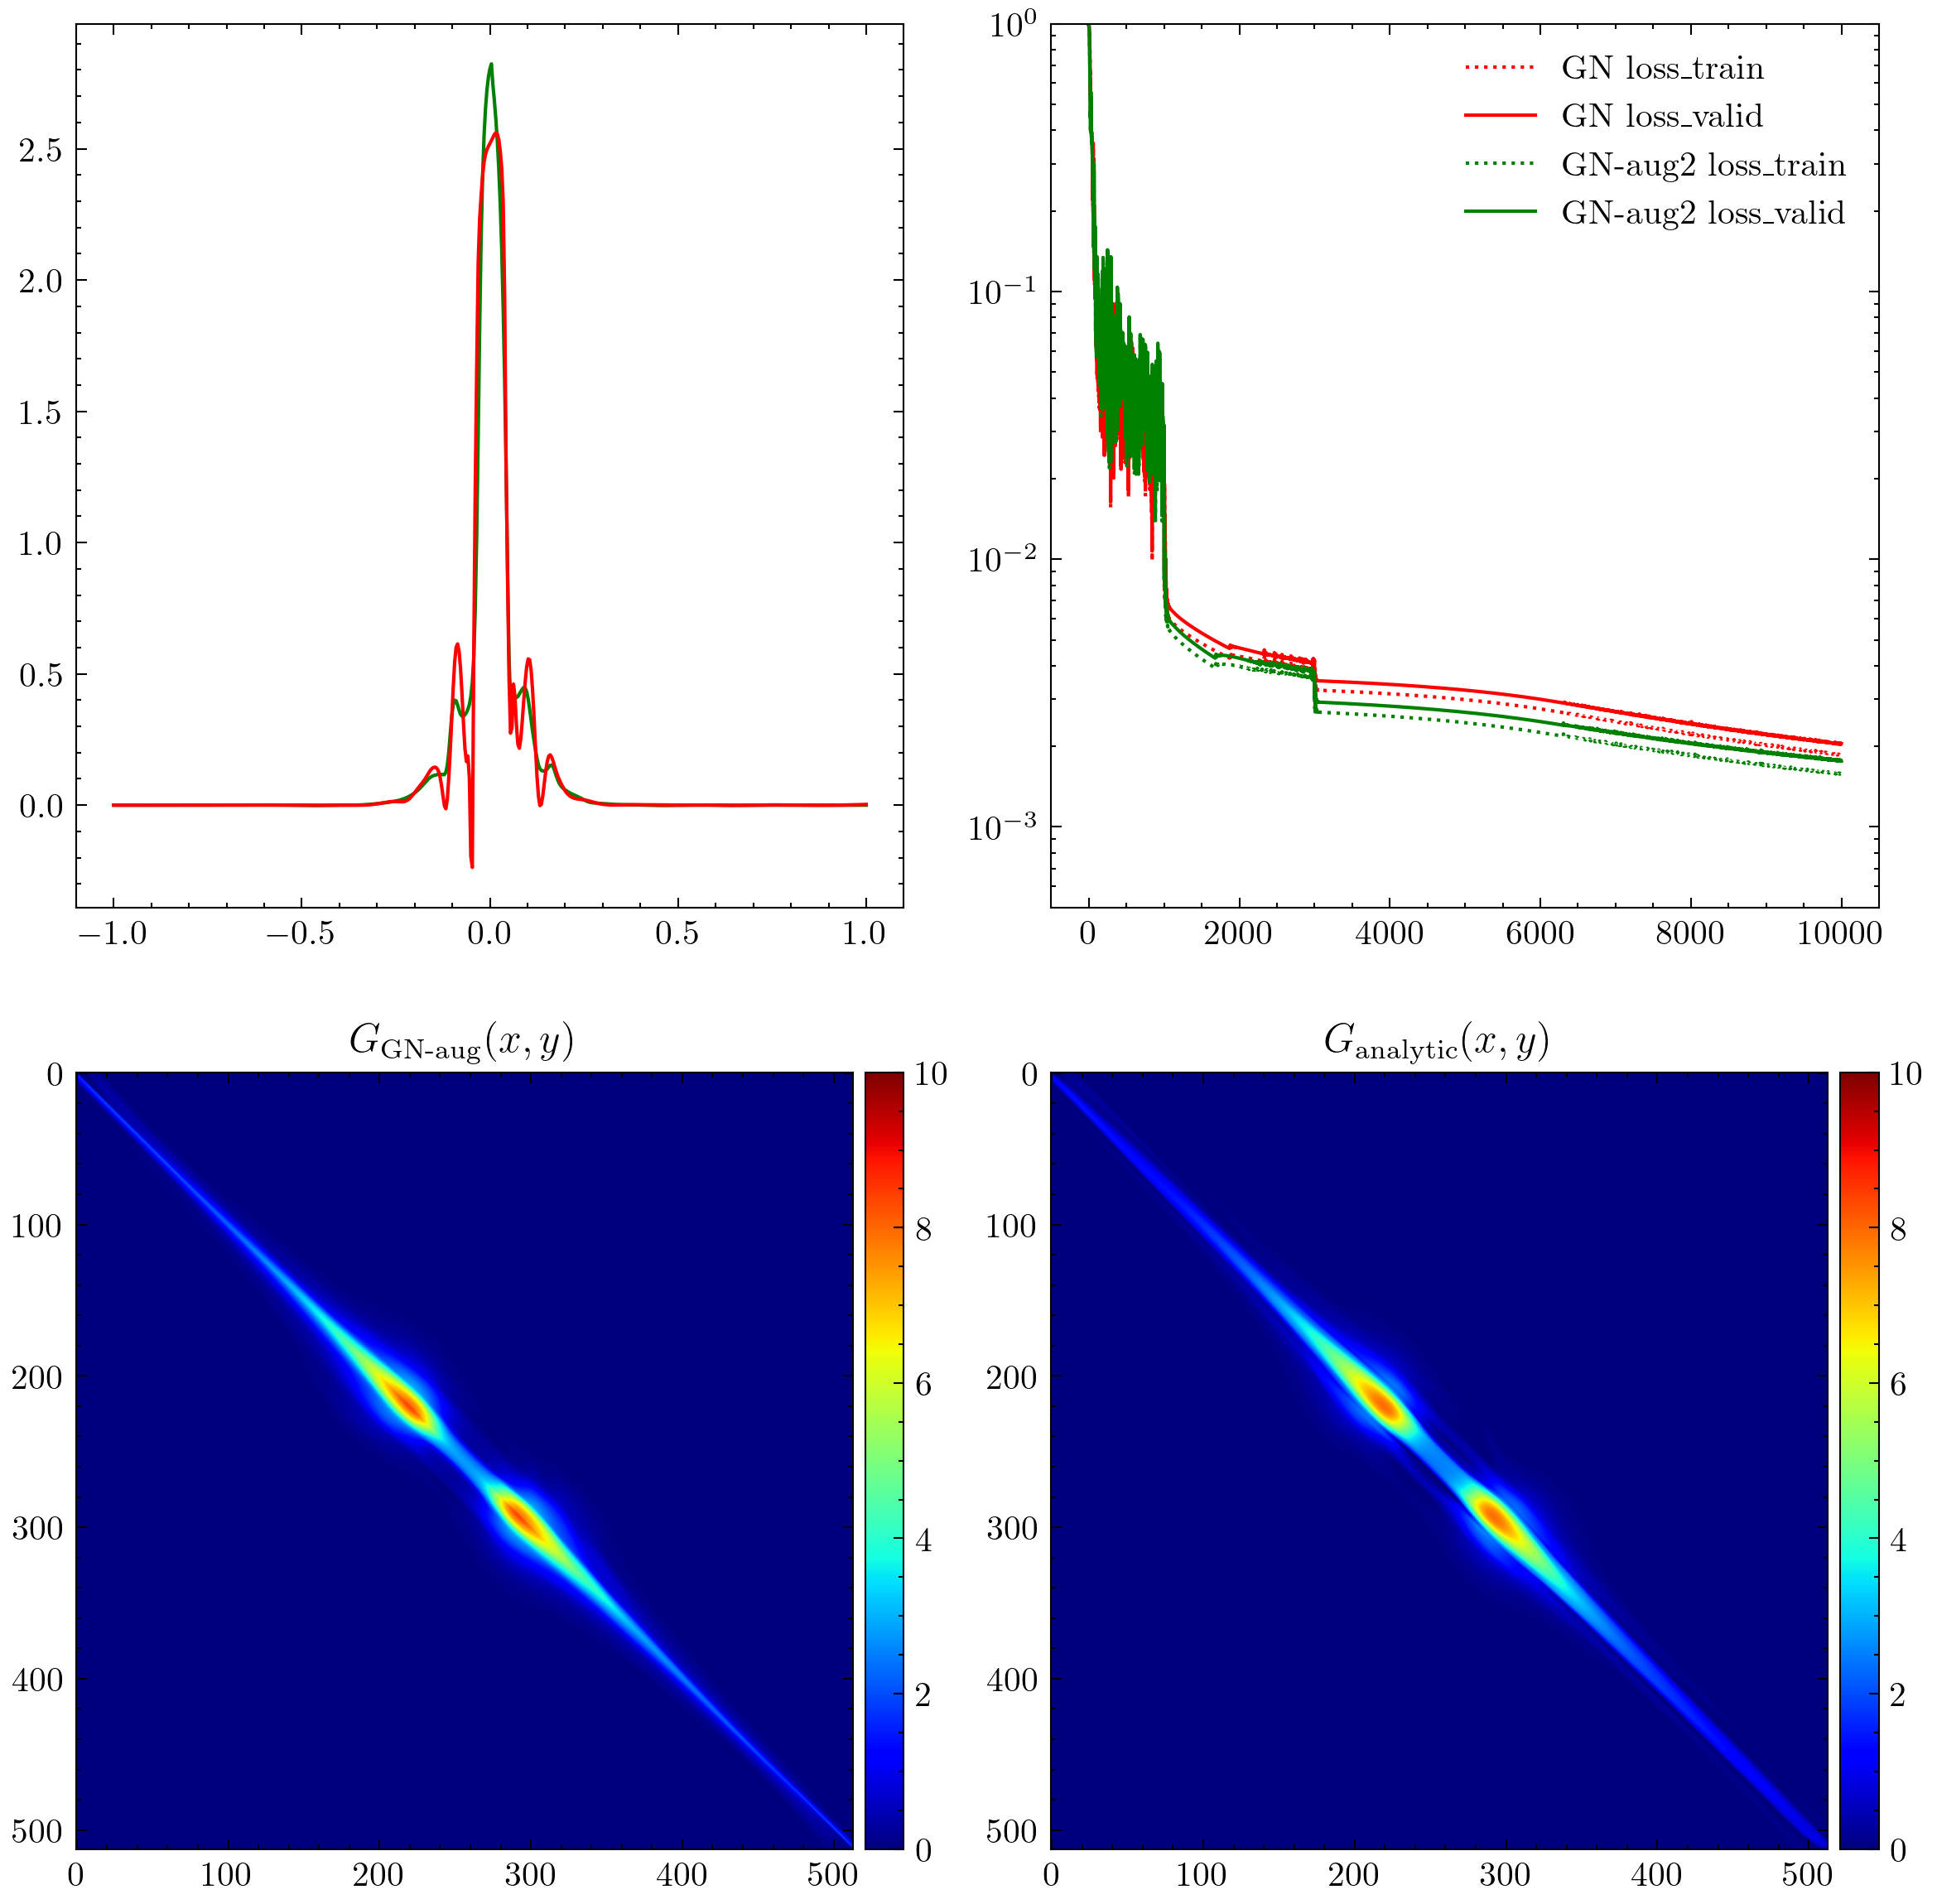

In [3]:
# load data
gn_schrodinger_df = pd.read_csv('../results/schrodinger1d/GN1D-rational-513-50-1.0000-none-4/hist.csv')
gnaug2_schrodinger_df = pd.read_csv('../results/schrodinger1d/GN1D-rational-513-50-1.0000-aug2-4/hist.csv')
gn_schrodinger_kernel = np.load('../results/schrodinger1d/GN1D-rational-513-50-1.0000-none-4/approx_kernel.npy')
gnaug2_schrodinger_kernel = np.load('../results/schrodinger1d/GN1D-rational-513-50-1.0000-aug2-4/approx_kernel.npy')

idx = 257
nh = 513
h = 6/(nh-1) # x in [-1, 1]
xh = torch.linspace(-1,1,nh)
x_i = torch.cartesian_prod(xh, xh)
G_gn = gn_schrodinger_kernel.reshape(513,513) / h
G_gnaug2 = gnaug2_schrodinger_kernel.reshape(513,513) / h

G_gn_ = G_gn[idx]
G_gnaug2_ = G_gnaug2[idx]

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)

ax1.plot(xh, G_gnaug2_, '-g',label='GN-aug2')
ax1.plot(xh, G_gn_, '-r', label='GN')

start = 0
end = 10000
idx = list(range(start, end, 1))
ax2.set_ylim(5e-4, 1)
ax2.set_yscale("log")
# ax2.set_xscale("log")
ax2.plot(idx, gn_schrodinger_df.train_rl2[start:end], label = "GN loss_train", color='red', linestyle=':')
ax2.plot(idx, gn_schrodinger_df.test_rl2[start:end], label = "GN loss_valid", color='red', linestyle='-')
ax2.plot(idx, gnaug2_schrodinger_df.train_rl2[start:end], label = "GN-aug2 loss_train", color='green', linestyle=':')
ax2.plot(idx, gnaug2_schrodinger_df.test_rl2[start:end], label = "GN-aug2 loss_valid", color='green', linestyle='-')
ax2.legend()
ax2.minorticks_on()

im3 = ax3.imshow(G_gnaug2, vmin=0, vmax=10, cmap='jet')
ax3.title.set_text('$G_{\\text{GN-aug}}(x,y)$')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='vertical')

im4 = ax4.imshow(G_gn, vmin=0, vmax=10, cmap='jet')
ax4.title.set_text('$G_{\\text{analytic}}(x,y)$')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im4, cax=cax, orientation='vertical')

plt.tight_layout()


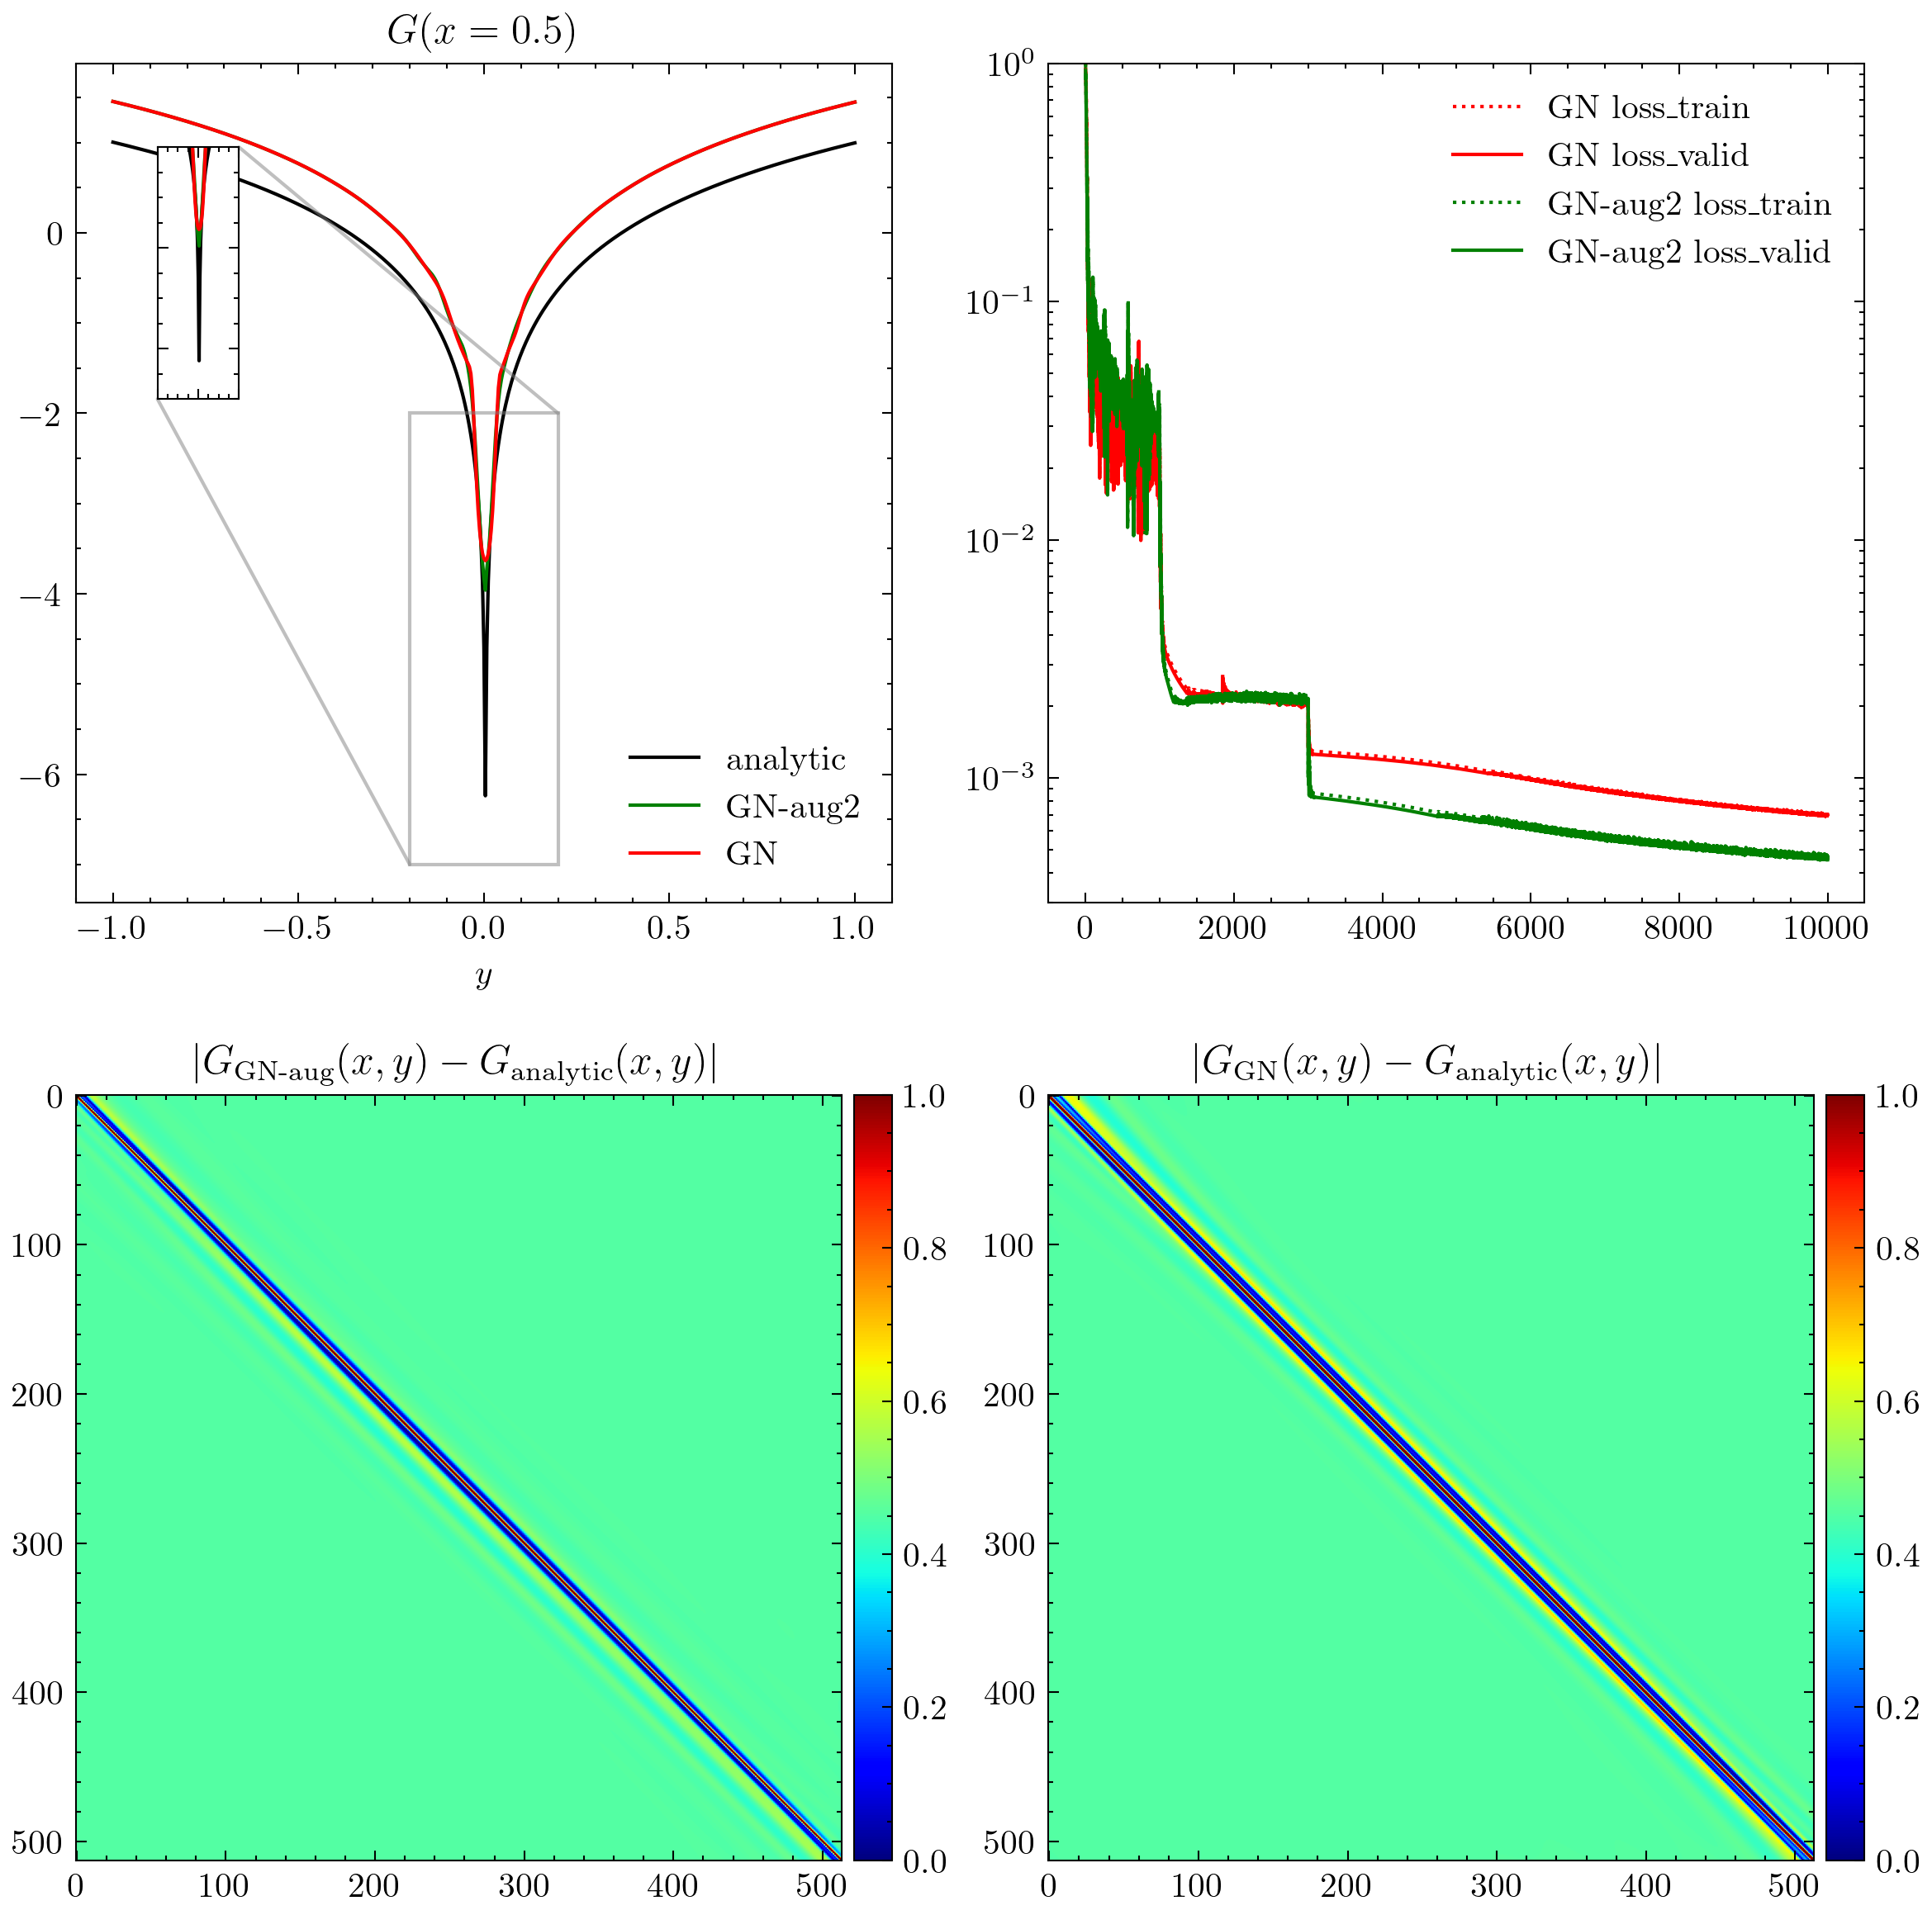

In [10]:
gn_log_df = pd.read_csv('../results/logarithm/GN1D-rational-513-50-1.0000-none-1/hist.csv')
# gnaug1_poisson_df = pd.read_csv('../results/poisson/GN1D-rational-513-50-1.0000-aug1-0/hist.csv')
gnaug2_log_df = pd.read_csv('../results/logarithm/GN1D-rational-513-50-1.0000-aug2-1/hist.csv')
gn_log_kernel = np.load('../results/logarithm/GN1D-rational-513-50-1.0000-none-1/approx_kernel.npy')
# gnaug1_poisson_kernel = np.load('../results/poisson/GN1D-rational-513-50-1.0000-aug1-0/approx_kernel.npy')
gnaug2_log_kernel = np.load('../results/logarithm/GN1D-rational-513-50-1.0000-aug2-1/approx_kernel.npy')

idx = 257
nh = 513
h = 2/(nh-1) # x in [-1, 1]
xh = torch.linspace(-1,1,nh)
x_i = torch.cartesian_prod(xh, xh)
G = logarithm_kernel(x_i[:,0], x_i[:,1], h).reshape(nh, nh)
G_gn = gn_log_kernel.reshape(513,513) / h
G_gnaug2 = gnaug2_log_kernel.reshape(513,513) / h
# G_gnaug1 = gnaug1_poisson_kernel.reshape(513,513) / h

G_ = G[idx]
G_gn_ = G_gn[idx]
# G_gnaug1_ = G_gnaug1[idx]
G_gnaug2_ = G_gnaug2[idx]

f = plt.figure(figsize=(8,8))
ax1 = f.add_subplot(221)
ax2 = f.add_subplot(222)
ax3 = f.add_subplot(223)
ax4 = f.add_subplot(224)
ax1.plot(xh, G_, '-k',label='analytic')
# ax1.plot(xh, G_gnaug1_, '-b',label='GN-aug1')
ax1.plot(xh, G_gnaug2_, '-g',label='GN-aug2')
ax1.plot(xh, G_gn_, '-r', label='GN')
ax1.title.set_text('$G(x=0.5)$')
ax1.set_xlabel('$y$')
axins = ax1.inset_axes(
    [0.1, 0.6, 0.1, 0.3], xlim=(-0.2, 0.2),ylim=(-7,-2),
    xticklabels=[], yticklabels=[])
axins.plot(xh, G_, '-k', label='analytic')
# axins.plot(xh, G_gnaug1_, '-b', label='GN-aug1')
axins.plot(xh, G_gnaug2_, '-g', label='GN-aug2')
axins.plot(xh, G_gn_, '-r', label='GN')
ax1.indicate_inset_zoom(axins)
ax1.legend()

start = 0
end = 10000
idx = list(range(start, end, 1))
ax2.set_ylim(3e-4, 1)
ax2.set_yscale("log")
# ax2.set_xscale("log")
ax2.plot(idx, gn_log_df.train_rl2[start:end], label = "GN loss_train", color='red', linestyle=':')
ax2.plot(idx, gn_log_df.test_rl2[start:end], label = "GN loss_valid", color='red', linestyle='-')
# ax2.plot(idx, gnaug1_poisson_df.train_rl2[start:end], label = "GN-aug1 loss", color='blue', linestyle='--')
# ax2.plot(idx, gnaug1_poisson_df.test_rl2[start:end], label = "GN-aug1 loss_valid", color='blue', linestyle='-')
ax2.plot(idx, gnaug2_log_df.train_rl2[start:end], label = "GN-aug2 loss_train", color='green', linestyle=':')
ax2.plot(idx, gnaug2_log_df.test_rl2[start:end], label = "GN-aug2 loss_valid", color='green', linestyle='-')
ax2.legend()
ax2.minorticks_on()

G_gnaug2_ae = np.abs(G - G_gnaug2)
G_gn_ae = np.abs(G - G_gn)
im3 = ax3.imshow(G_gnaug2_ae, vmin=0, vmax=1, cmap='jet')
ax3.title.set_text('$|G_{\\text{GN-aug}}(x,y)-G_{\\text{analytic}}(x,y)|$')
divider = make_axes_locatable(ax3)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im3, cax=cax, orientation='vertical')

im4 = ax4.imshow(G_gn_ae, vmin=0, vmax=1, cmap='jet')
ax4.title.set_text('$|G_{\\text{GN}}(x,y)-G_{\\text{analytic}}(x,y)|$')
divider = make_axes_locatable(ax4)
cax = divider.append_axes('right', size='5%', pad=0.05)
f.colorbar(im4, cax=cax, orientation='vertical')

plt.tight_layout()

Result of GN with subset training points

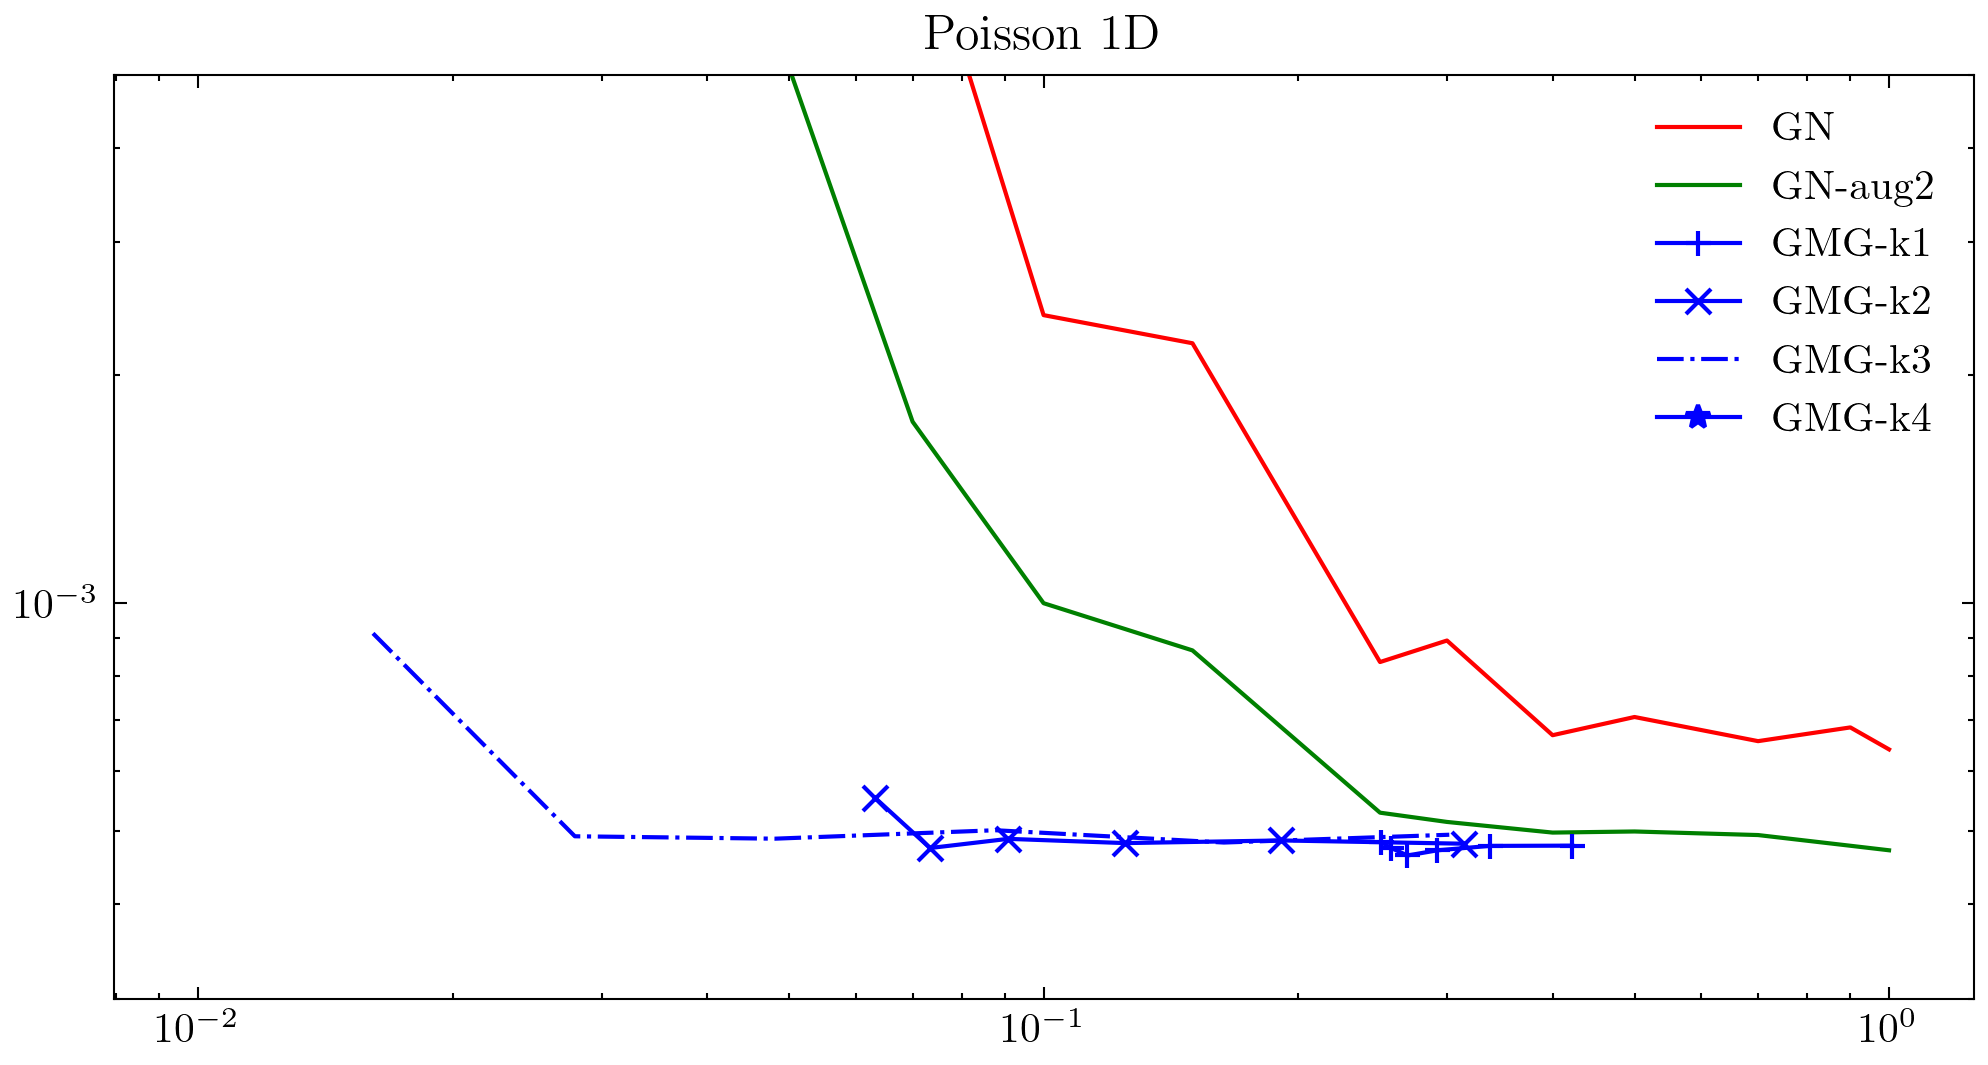

In [5]:
ps = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.25, 0.30, 0.4, 0.5, 0.7, 0.9, 1.0]

gnaug_poisson_df_p_lst = []
gn_poisson_df_p_lst = []

for s in [0, 1, 2, 3, 4]:
    gnaug_poisson_df_p = []
    gn_poisson_df_p = []
    gnaug_log_df_p = []
    gn_log_df_p = []

    gnaug_poisson_df_pattern = '../results/poisson1d/GN1D-rational-513-50-{:}-aug2-{:}/hist.csv'
    gn_poisson_df_pattern = '../results/poisson1d/GN1D-rational-513-50-{:}-none-{:}/hist.csv'

    for p in ps:
        p = '{:.4f}'.format(p)
        gnaug_poisson_df_p.append(pd.read_csv(gnaug_poisson_df_pattern.format(p, s)).test_rl2.values[-1])
        gn_poisson_df_p.append(pd.read_csv(gn_poisson_df_pattern.format(p, s)).test_rl2.values[-1])
    
    gnaug_poisson_df_p_lst.append(np.array(gnaug_poisson_df_p))
    gn_poisson_df_p_lst.append(np.array(gn_poisson_df_p))    

gnaug_poisson_df_p_lst = np.array(gnaug_poisson_df_p_lst).mean(axis=0)
gn_poisson_df_p_lst = np.array(gn_poisson_df_p_lst).mean(axis=0)

exp_df = create_expdf('../results')
ddgmgk1 = exp_df[(exp_df.task_nm=='poisson1d') & (exp_df.k==1)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk2 = exp_df[(exp_df.task_nm=='poisson1d') & (exp_df.k==2)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk3 = exp_df[(exp_df.task_nm=='poisson1d') & (exp_df.k==3)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk4 = exp_df[(exp_df.task_nm=='poisson1d') & (exp_df.k==4)].groupby(['k','m','p'])['rl2'].mean().reset_index()

# ddgmgk5 = exp_df[(exp_df.task_nm=='poisson') & (exp_df.k==5)]
# ddgmgk7 = exp_df[(exp_df.task_nm=='poisson') & (exp_df.k==7)]

f = plt.figure(figsize=(8,4))
ax_poisson = f.add_subplot(111)
# ax_log = f.add_subplot(122)
ax_poisson.plot(ps, gn_poisson_df_p_lst, '-r', label='GN')
ax_poisson.plot(ps, gnaug_poisson_df_p_lst, '-g', label='GN-aug2')
ax_poisson.plot(ddgmgk1.p, ddgmgk1.rl2, '-+b', label='GMG-k1')
ax_poisson.plot(ddgmgk2.p, ddgmgk2.rl2, '-xb', label='GMG-k2')
ax_poisson.plot(ddgmgk3.p, ddgmgk3.rl2, '-.b', label='GMG-k3')
ax_poisson.plot(ddgmgk4.p, ddgmgk4.rl2, '-*b', label='GMG-k4')
# ax_poisson.plot(ddgmgk5.p, ddgmgk5.rl2, 'x-b', label='DDGMG-k5')
# ax_poisson.plot(ddgmgk7.p, ddgmgk7.rl2, '+-b', label='DDGMG-k7')
ax_poisson.set_ylim(3e-4, 5e-3)
ax_poisson.set_yscale("log")
ax_poisson.set_xscale("log")
ax_poisson.legend()
ax_poisson.minorticks_on()
ax_poisson.title.set_text("Poisson 1D")
# ax_log.plot(ps, gn_log_df_p_lst, '-r', label='GN')
# ax_log.plot(ps, gnaug_log_df_p_lst, '-g', label='GN-aug2')
# ax_log.set_yscale("log")
# ax_log.set_xscale("log")
# ax_log.legend()
# ax_log.minorticks_on()
# ax_log.title.set_text('Logarithm 1D')

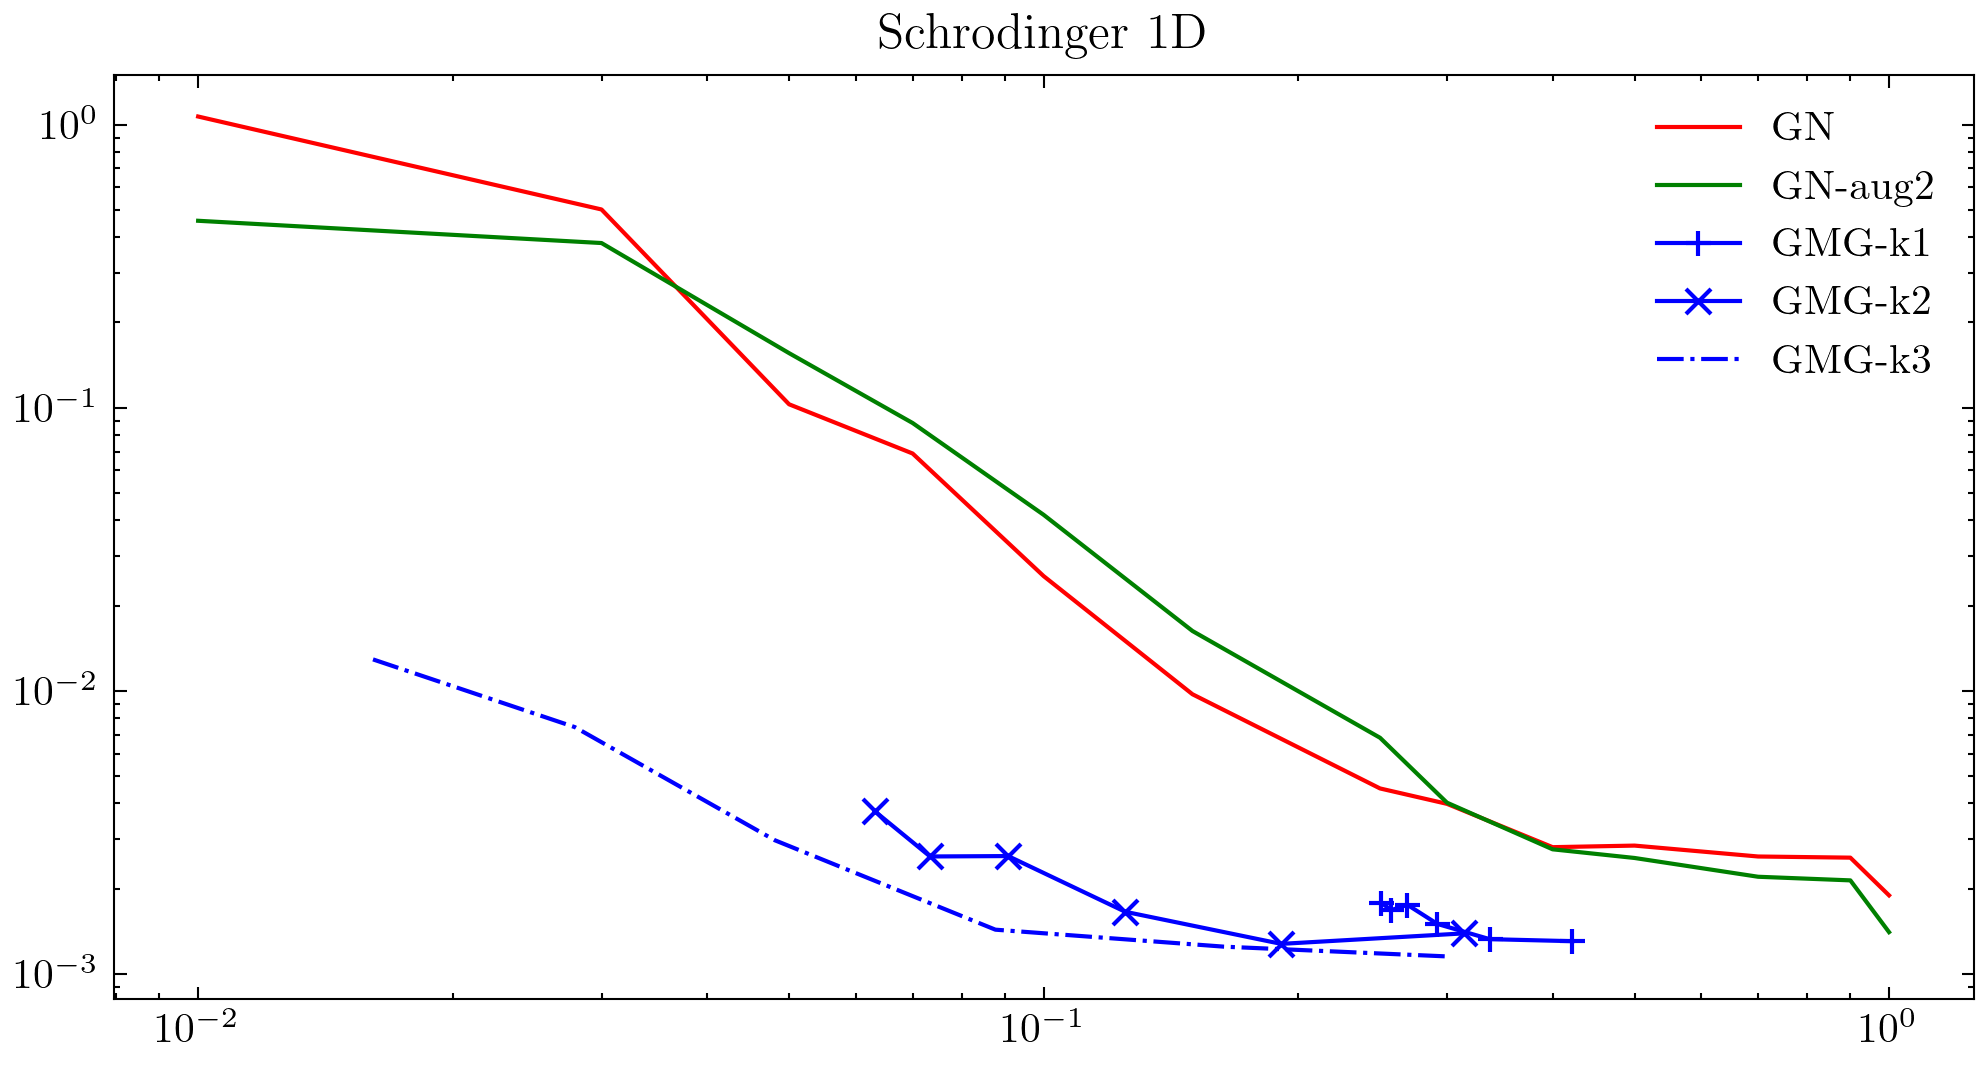

In [6]:
ps = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.25, 0.30, 0.4, 0.5, 0.7, 0.9, 1.0]

gnaug_schrodinger_df_p_lst = []
gn_schrodinger_df_p_lst = []

for s in [0, 1,2,3,4]:
    gnaug_schrodinger_df_p = []
    gn_schrodinger_df_p = []

    gnaug_schrodinger_df_pattern = '../results/schrodinger1d/GN1D-rational-513-50-{:}-aug2-{:}/hist.csv'
    gn_schrodinger_df_pattern = '../results/schrodinger1d/GN1D-rational-513-50-{:}-none-{:}/hist.csv'

    for p in ps:
        p = '{:.4f}'.format(p)
        gnaug_schrodinger_df_p.append(pd.read_csv(gnaug_schrodinger_df_pattern.format(p, s)).test_rl2.values[-1])
        gn_schrodinger_df_p.append(pd.read_csv(gn_schrodinger_df_pattern.format(p, s)).test_rl2.values[-1])
    
    gnaug_schrodinger_df_p_lst.append(np.array(gnaug_schrodinger_df_p))
    gn_schrodinger_df_p_lst.append(np.array(gn_schrodinger_df_p))    

gnaug_schrodinger_df_p_lst = np.array(gnaug_schrodinger_df_p_lst).mean(axis=0)
gn_schrodinger_df_p_lst = np.array(gn_schrodinger_df_p_lst).mean(axis=0)

exp_df = create_expdf('../results')
ddgmgk1 = exp_df[(exp_df.task_nm=='schrodinger1d') & (exp_df.k==1)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk2 = exp_df[(exp_df.task_nm=='schrodinger1d') & (exp_df.k==2)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk3 = exp_df[(exp_df.task_nm=='schrodinger1d') & (exp_df.k==3)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk4 = exp_df[(exp_df.task_nm=='schrodinger1d') & (exp_df.k==4)].groupby(['k','m','p'])['rl2'].mean().reset_index()

# ddgmgk5 = exp_df[(exp_df.task_nm=='poisson') & (exp_df.k==5)]
# ddgmgk7 = exp_df[(exp_df.task_nm=='poisson') & (exp_df.k==7)]

f = plt.figure(figsize=(8,4))
ax_poisson = f.add_subplot(111)
# ax_log = f.add_subplot(122)
ax_poisson.plot(ps, gn_schrodinger_df_p_lst, '-r', label='GN')
ax_poisson.plot(ps, gnaug_schrodinger_df_p_lst, '-g', label='GN-aug2')
ax_poisson.plot(ddgmgk1.p, ddgmgk1.rl2, '-+b', label='GMG-k1')
ax_poisson.plot(ddgmgk2.p, ddgmgk2.rl2, '-xb', label='GMG-k2')
ax_poisson.plot(ddgmgk3.p, ddgmgk3.rl2, '-.b', label='GMG-k3')
# ax_poisson.plot(ddgmgk4.p, ddgmgk4.rl2, '*b', label='GMG-k4')
# ax_poisson.plot(ddgmgk5.p, ddgmgk5.rl2, 'x-b', label='DDGMG-k5')
# ax_poisson.plot(ddgmgk7.p, ddgmgk7.rl2, '+-b', label='DDGMG-k7')
# ax_poisson.set_ylim(1e-4, 1e-2)
ax_poisson.set_yscale("log")
ax_poisson.set_xscale("log")
ax_poisson.legend()
ax_poisson.minorticks_on()
ax_poisson.title.set_text("Schrodinger 1D")
# ax_log.plot(ps, gn_log_df_p_lst, '-r', label='GN')
# ax_log.plot(ps, gnaug_log_df_p_lst, '-g', label='GN-aug2')
# ax_log.set_yscale("log")
# ax_log.set_xscale("log")
# ax_log.legend()
# ax_log.minorticks_on()
# ax_log.title.set_text('Logarithm 1D')

In [13]:
ps = [0.01, 0.03, 0.05, 0.07, 0.1, 0.15, 0.25, 0.30, 0.4, 0.5, 0.7, 0.9, 1.0]

gnaug_airy_df_p_lst = []
gn_airy_df_p_lst = []

for s in [0, 1, 2, 3]:
    gnaug_airy_df_p = []
    gn_airy_df_p = []
    gnaug_log_df_p = []
    gn_log_df_p = []

    gnaug_airy_df_pattern = '../results/airy1d/GN1D-rational-513-50-{:}-aug2-{:}/hist.csv'
    gn_airy_df_pattern = '../results/airy1d/GN1D-rational-513-50-{:}-none-{:}/hist.csv'

    for p in ps:
        p = '{:.4f}'.format(p)
        gnaug_airy_df_p.append(pd.read_csv(gnaug_airy_df_pattern.format(p, s)).test_rl2.values[-1])
        gn_airy_df_p.append(pd.read_csv(gn_airy_df_pattern.format(p, s)).test_rl2.values[-1])
    
    gnaug_airy_df_p_lst.append(np.array(gnaug_airy_df_p))
    gn_airy_df_p_lst.append(np.array(gn_airy_df_p))    

gnaug_airy_df_p_lst = np.array(gnaug_airy_df_p_lst).mean(axis=0)
gn_airy_df_p_lst = np.array(gn_airy_df_p_lst).mean(axis=0)

exp_df = create_expdf('../results')
ddgmgk1 = exp_df[(exp_df.task_nm=='airy1d') & (exp_df.k==1)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk2 = exp_df[(exp_df.task_nm=='airy1d') & (exp_df.k==2)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk3 = exp_df[(exp_df.task_nm=='airy1d') & (exp_df.k==3)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk4 = exp_df[(exp_df.task_nm=='airy1d') & (exp_df.k==4)].groupby(['k','m','p'])['rl2'].mean().reset_index()

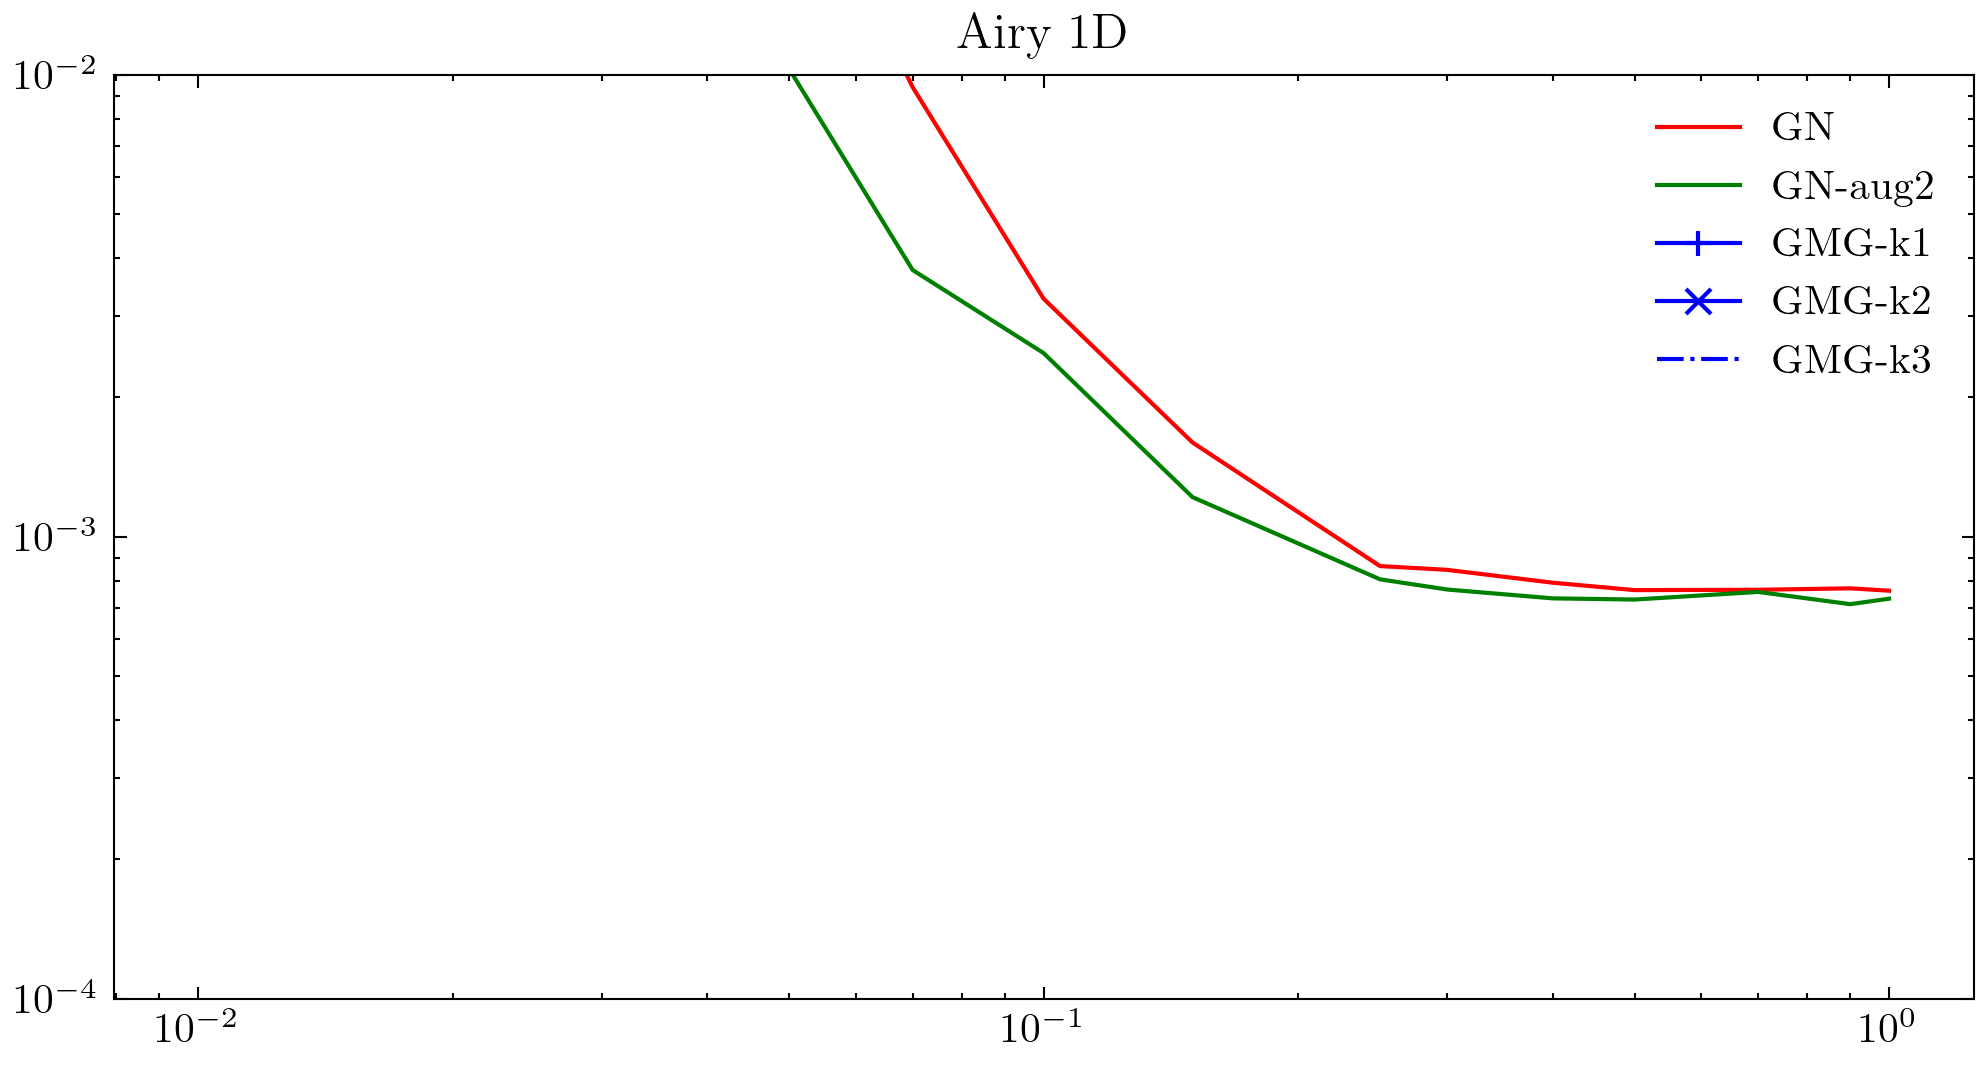

In [14]:
f = plt.figure(figsize=(8,4))
ax_poisson = f.add_subplot(111)
# ax_log = f.add_subplot(122)
ax_poisson.plot(ps, gn_airy_df_p_lst, '-r', label='GN')
ax_poisson.plot(ps, gnaug_airy_df_p_lst, '-g', label='GN-aug2')
ax_poisson.plot(ddgmgk1.p, ddgmgk1.rl2, '-+b', label='GMG-k1')
ax_poisson.plot(ddgmgk2.p, ddgmgk2.rl2, '-xb', label='GMG-k2')
ax_poisson.plot(ddgmgk3.p, ddgmgk3.rl2, '-.b', label='GMG-k3')
ax_poisson.set_ylim(1e-4, 1e-2)
ax_poisson.set_yscale("log")
ax_poisson.set_xscale("log")
ax_poisson.legend()
ax_poisson.minorticks_on()
ax_poisson.title.set_text("Airy 1D")

Result of GN and GN-aug on 2D problems

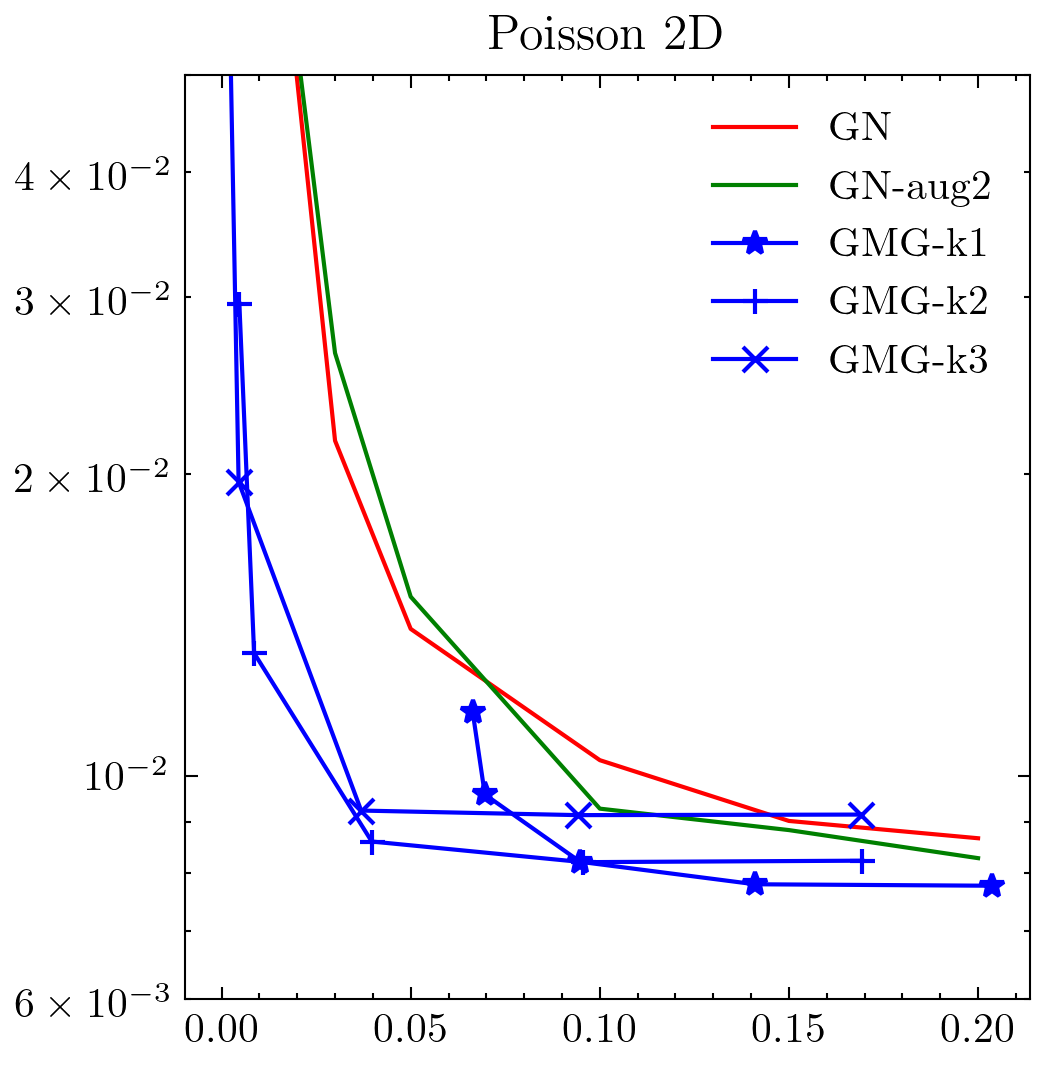

In [9]:
ps = [0.001, 0.005, 0.03, 0.05, 0.1, 0.15, 0.2]
gnaug_poissonrect_df_p_lst = []
gn_poissonrect_df_p_lst = []

for s in [0, 1, 2, 3, 4]:
    gnaug_poissonrect_df_p = []
    gn_poissonrect_df_p = []

    gnaug_poissonrect_df_pattern = '../results/poissonrect/GN2D-rational-65x65-50-{:}-aug2-{:}/hist.csv'
    gn_poissonrect_df_pattern = '../results/poissonrect/GN2D-rational-65x65-50-{:}-none-{:}/hist.csv'

    for p in ps:
        p = '{:.4f}'.format(p)
        gnaug_poissonrect_df_p.append(pd.read_csv(gnaug_poissonrect_df_pattern.format(p, s)).test_rl2.values[-1])
        gn_poissonrect_df_p.append(pd.read_csv(gn_poissonrect_df_pattern.format(p, s)).test_rl2.values[-1])
    
    gnaug_poissonrect_df_p_lst.append(np.array(gnaug_poissonrect_df_p))
    gn_poissonrect_df_p_lst.append(np.array(gn_poissonrect_df_p))    

gnaug_poissonrect_df_p_lst = np.array(gnaug_poissonrect_df_p_lst).mean(axis=0)
gn_poissonrect_df_p_lst = np.array(gn_poissonrect_df_p_lst).mean(axis=0)

exp_df = create_expdf('../results')
ddgmgk1 = exp_df[(exp_df.task_nm=='poissonrect') & (exp_df.k==1)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk2 = exp_df[(exp_df.task_nm=='poissonrect') & (exp_df.k==2)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk3 = exp_df[(exp_df.task_nm=='poissonrect') & (exp_df.k==3)].groupby(['k','m','p'])['rl2'].mean().reset_index()

f = plt.figure(figsize=(8,4))
ax_poisson = f.add_subplot(121)
# ax_log = f.add_subplot(122)
ax_poisson.plot(ps, gn_poissonrect_df_p_lst, '-r', label='GN')
ax_poisson.plot(ps, gnaug_poissonrect_df_p_lst, '-g', label='GN-aug2')
# ax_poisson.plot(ddgmgk5.p, ddgmgk5.rl2, 'x-b', label='DDGMG-k5')
# ax_poisson.plot(ddgmgk7.p, ddgmgk7.rl2, '+-b', label='DDGMG-k7')
ax_poisson.set_ylim(6e-3, 5e-2)
ax_poisson.set_yscale("log")
# ax_poisson.set_xscale("log")
ax_poisson.plot(ddgmgk1.p, ddgmgk1.rl2, '-*b', label='GMG-k1')
ax_poisson.plot(ddgmgk2.p, ddgmgk2.rl2, '-+b', label='GMG-k2')
ax_poisson.plot(ddgmgk3.p, ddgmgk3.rl2, '-xb', label='GMG-k3')
ax_poisson.legend()
ax_poisson.minorticks_on()
ax_poisson.title.set_text("Poisson 2D")

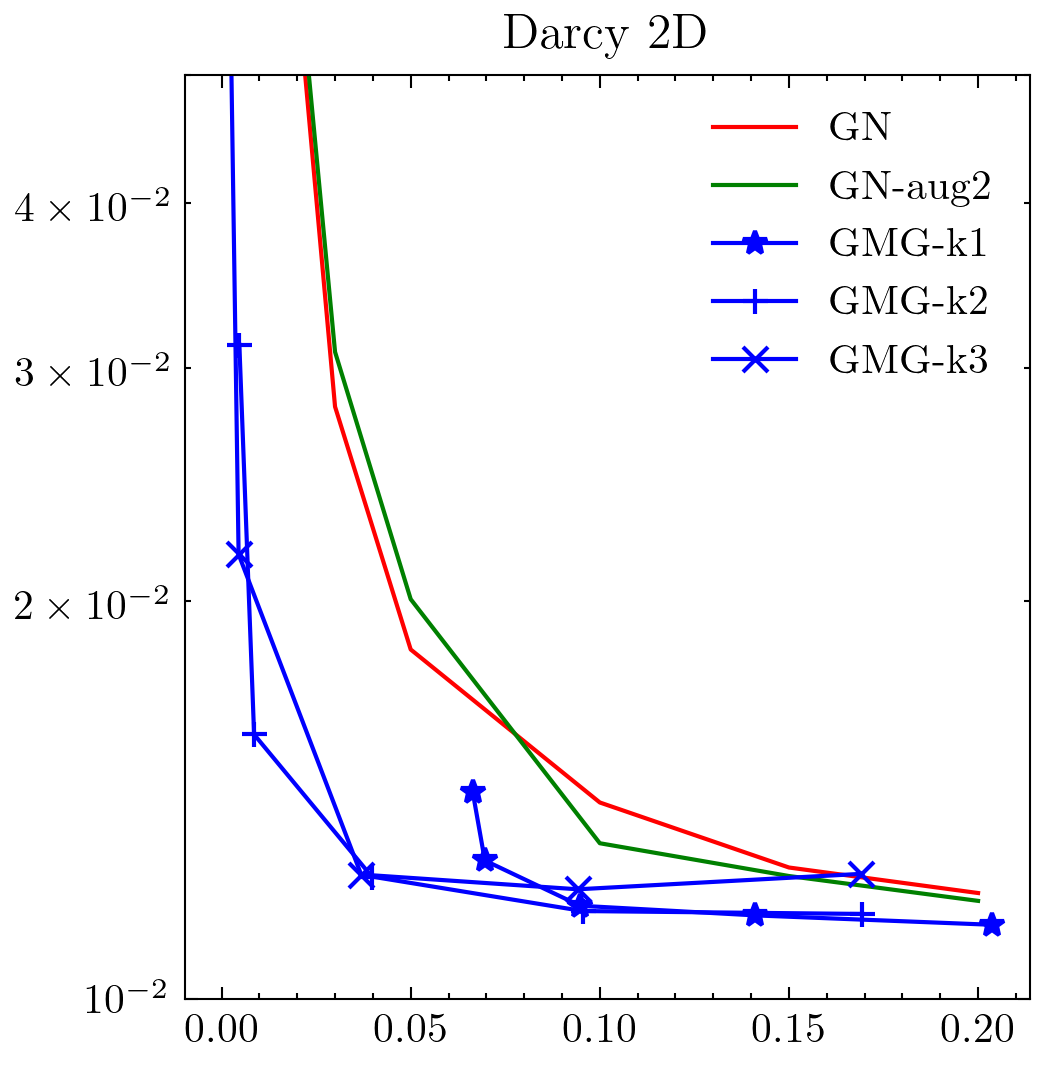

In [29]:
ps = [0.001, 0.005, 0.03, 0.05, 0.1, 0.15, 0.2]
gnaug_darcyrect_df_p_lst = []
gn_darcyrect_df_p_lst = []

for s in [0,1,2,3,4]:#, 1, 2, 3, 4]:
    gnaug_darcyrect_df_p = []
    gn_darcyrect_df_p = []

    gnaug_darcyrect_df_pattern = '../results/darcyrect/GN2D-rational-65x65-50-{:}-aug2-{:}/hist.csv'
    gn_darcyrect_df_pattern = '../results/darcyrect/GN2D-rational-65x65-50-{:}-none-{:}/hist.csv'

    for p in ps:
        p = '{:.4f}'.format(p)
        gnaug_darcyrect_df_p.append(pd.read_csv(gnaug_darcyrect_df_pattern.format(p, s)).test_rl2.values[-1])
        gn_darcyrect_df_p.append(pd.read_csv(gn_darcyrect_df_pattern.format(p, s)).test_rl2.values[-1])
    
    gnaug_darcyrect_df_p_lst.append(np.array(gnaug_darcyrect_df_p))
    gn_darcyrect_df_p_lst.append(np.array(gn_darcyrect_df_p))    

gnaug_darcyrect_df_p_lst = np.array(gnaug_darcyrect_df_p_lst).mean(axis=0)
gn_darcyrect_df_p_lst = np.array(gn_darcyrect_df_p_lst).mean(axis=0)

exp_df = create_expdf('../results')
ddgmgk1 = exp_df[(exp_df.task_nm=='darcyrect') & (exp_df.k==1)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk2 = exp_df[(exp_df.task_nm=='darcyrect') & (exp_df.k==2)].groupby(['k','m','p'])['rl2'].mean().reset_index()
ddgmgk3 = exp_df[(exp_df.task_nm=='darcyrect') & (exp_df.k==3)].groupby(['k','m','p'])['rl2'].mean().reset_index()

f = plt.figure(figsize=(8,4))
ax_darcy = f.add_subplot(121)
# ax_log = f.add_subplot(122)
ax_darcy.plot(ps, gn_darcyrect_df_p_lst, '-r', label='GN')
ax_darcy.plot(ps, gnaug_darcyrect_df_p_lst, '-g', label='GN-aug2')
# ax_poisson.plot(ddgmgk5.p, ddgmgk5.rl2, 'x-b', label='DDGMG-k5')
# ax_poisson.plot(ddgmgk7.p, ddgmgk7.rl2, '+-b', label='DDGMG-k7')
ax_darcy.set_ylim(1e-2, 5e-2)
ax_darcy.set_yscale("log")
# ax_poisson.set_xscale("log")
ax_darcy.plot(ddgmgk1.p, ddgmgk1.rl2, '-*b', label='GMG-k1')
ax_darcy.plot(ddgmgk2.p, ddgmgk2.rl2, '-+b', label='GMG-k2')
ax_darcy.plot(ddgmgk3.p, ddgmgk3.rl2, '-xb', label='GMG-k3')
ax_darcy.legend()
ax_darcy.minorticks_on()
ax_darcy.title.set_text("Darcy 2D")

In [17]:
ddgmgk3

,k,m,p,rl2
0,3,0,4.0000e-04,1.3289e-01
1,3,1,4.5000e-03,2.1641e-02
2,3,3,3.6900e-02,1.2410e-02
3,3,5,9.4200e-02,1.2096e-02
4,3,7,1.6910e-01,1.2425e-02


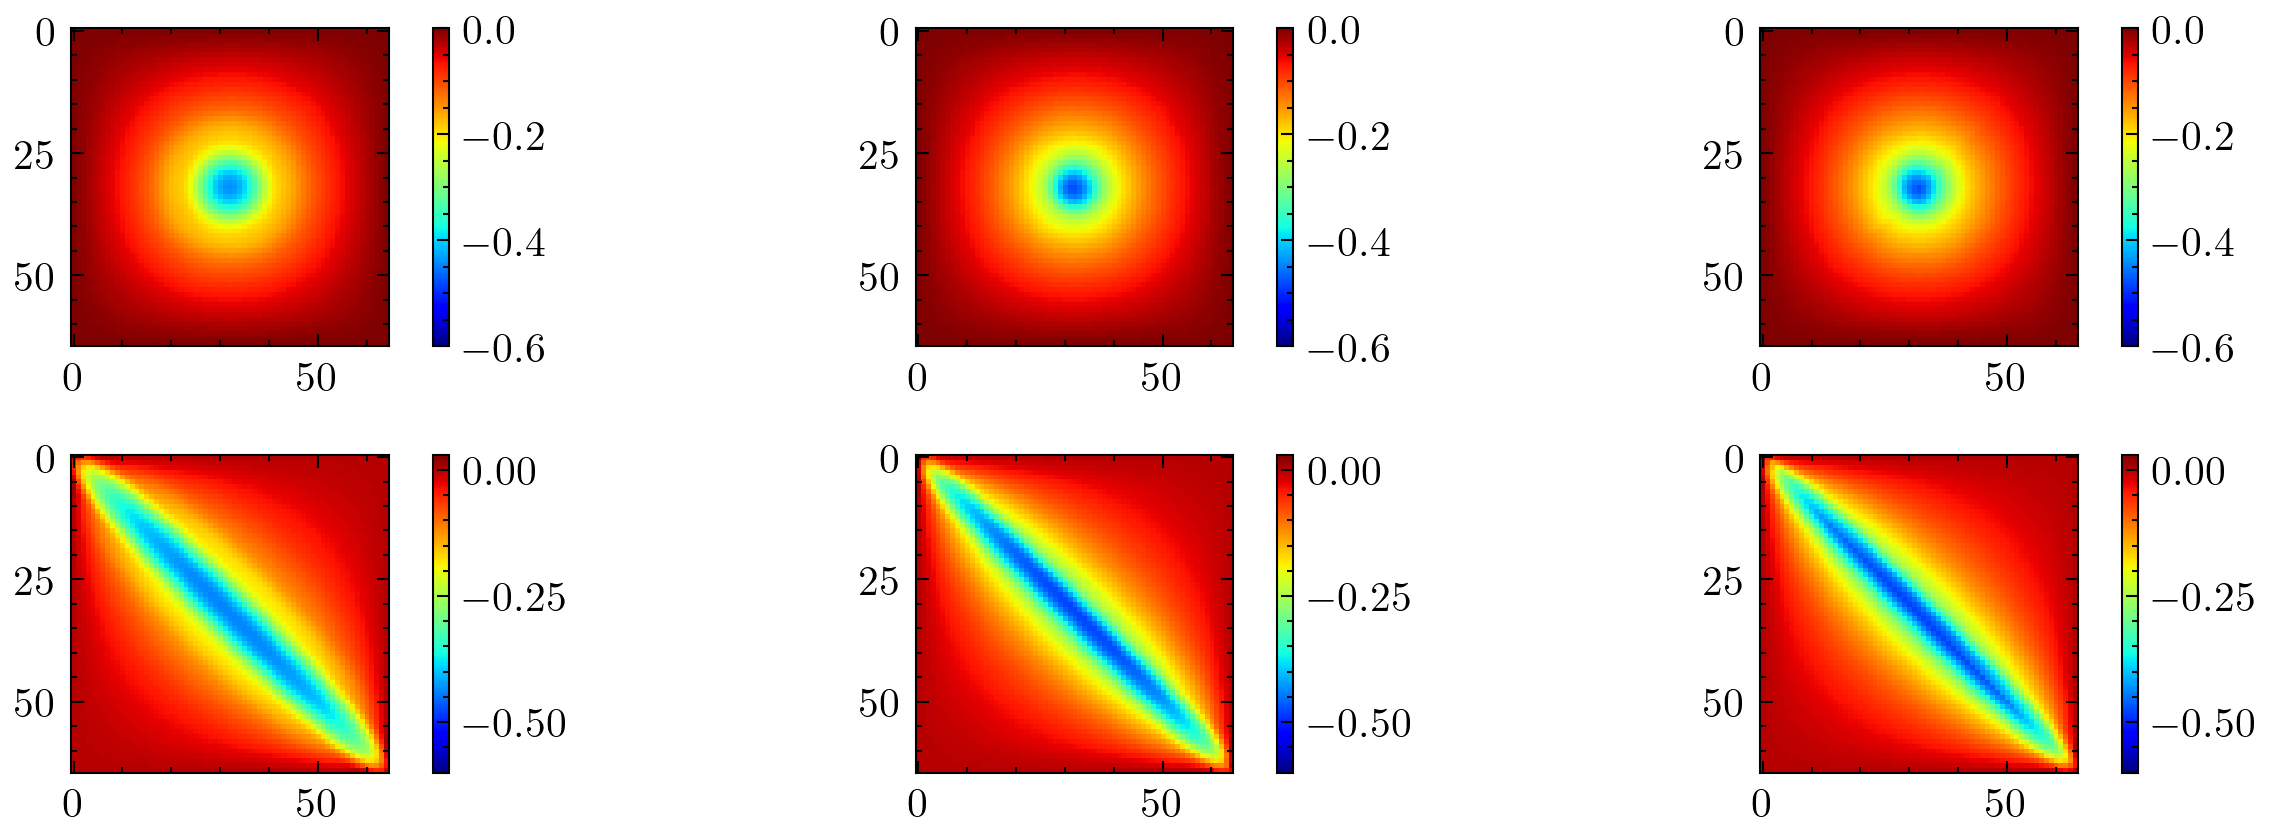

In [18]:
gn_poissonrect_kernel = np.load('../results/poissonrect/GN2D-rational-65x65-50-0.2000-none-1/approx_kernel.npy')
gnaug2_poissonrect_kernel = np.load('../results/poissonrect/GN2D-rational-65x65-50-0.2000-aug2-1/approx_kernel.npy')
gmgn_poissonrect_kernel = np.load('../results/poissonrect/DD_GMGN2D-rational-65x65-50-1-7-0.2036-aug2-1/approx_kernel.npy')

h = 2/(65-1)
poissonrect_kernel_gn = gn_poissonrect_kernel.reshape(65,65,65,65) *4
poissonrect_kernel_gnaug = gnaug2_poissonrect_kernel.reshape(65,65,65,65) * 4
poissonrect_kernel_gmgn = gmgn_poissonrect_kernel.reshape(65,65,65,65) * 4

plt.figure(figsize=(9,3))
plt.subplot(231)
plt.imshow(poissonrect_kernel_gn[:,:,32,32], vmin=-0.6, vmax=0.0, cmap='jet')
plt.colorbar()
plt.subplot(232)
plt.imshow(poissonrect_kernel_gnaug[:,:,32,32], vmin=-0.6, vmax=0.0, cmap='jet')
plt.colorbar()
plt.subplot(233)
plt.imshow(poissonrect_kernel_gmgn[:,:,32,32], vmin=-0.6, vmax=0.0, cmap='jet')
plt.colorbar()
plt.subplot(234)
plt.imshow(poissonrect_kernel_gn[32,:,32,:], vmin=-0.6, vmax=0.03, cmap='jet')
plt.colorbar()
plt.subplot(235)
plt.imshow(poissonrect_kernel_gnaug[32,:,32,:], vmin=-0.6, vmax=0.03, cmap='jet')
plt.colorbar()
plt.subplot(236)
plt.imshow(poissonrect_kernel_gmgn[32,:,32,:], vmin=-0.6, vmax=0.03, cmap='jet')
plt.colorbar()
plt.tight_layout()

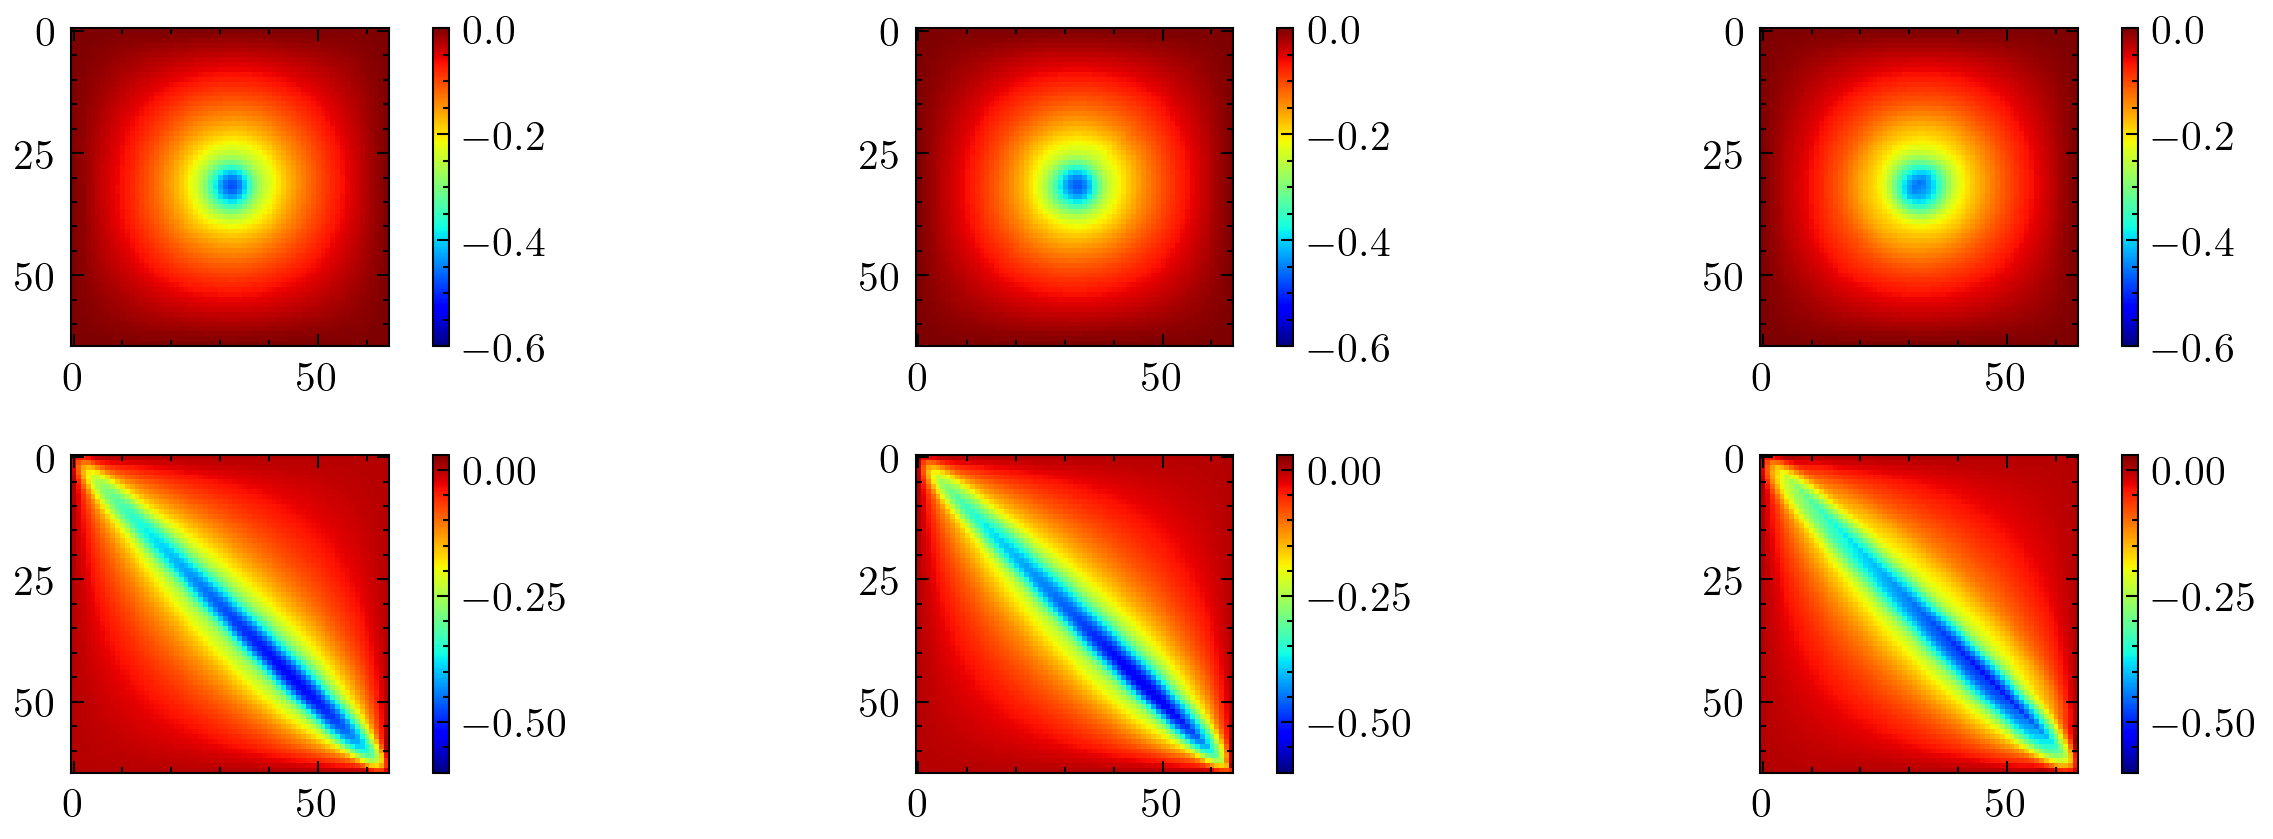

In [6]:
gn_darcyrect_kernel = np.load('../results/darcyrect/GN2D-rational-65x65-50-0.2000-none-3/approx_kernel.npy')
gnaug2_darcyrect_kernel = np.load('../results/darcyrect/GN2D-rational-65x65-50-0.2000-aug2-3/approx_kernel.npy')
gmgn_darcyrect_kernel = np.load('../results/darcyrect/DD_GMGN2D-rational-65x65-50-1-5-0.1410-aug2-0/approx_kernel.npy')

h = 2/(65-1)
darcyrect_kernel_gn = gn_darcyrect_kernel.reshape(65,65,65,65) *4
darcyrect_kernel_gnaug = gnaug2_darcyrect_kernel.reshape(65,65,65,65) * 4
darcyrect_kernel_gmgn = gmgn_darcyrect_kernel.reshape(65,65,65,65) * 4

plt.figure(figsize=(9,3))
plt.subplot(231)
plt.imshow(darcyrect_kernel_gn[:,:,32,32], vmin=-0.6, vmax=0.0, cmap='jet')
plt.colorbar()
plt.subplot(232)
plt.imshow(darcyrect_kernel_gnaug[:,:,32,32], vmin=-0.6, vmax=0.0, cmap='jet')
plt.colorbar()
plt.subplot(233)
plt.imshow(darcyrect_kernel_gmgn[:,:,32,32], vmin=-0.6, vmax=0.0, cmap='jet')
plt.colorbar()
plt.subplot(234)
plt.imshow(darcyrect_kernel_gn[32,:,32,:], vmin=-0.6, vmax=0.03, cmap='jet')
plt.colorbar()
plt.subplot(235)
plt.imshow(darcyrect_kernel_gnaug[32,:,32,:], vmin=-0.6, vmax=0.03, cmap='jet')
plt.colorbar()
plt.subplot(236)
plt.imshow(darcyrect_kernel_gmgn[32,:,32,:], vmin=-0.6, vmax=0.03, cmap='jet')
plt.colorbar()
plt.tight_layout()